<a href="https://colab.research.google.com/github/nilesh2gupta/UBC_project/blob/main/Combining_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy networkx
!pip install spacy spacy-entity-linker wikipedia-api
!pip install mwparserfromhell
!pip install wptools
!pip install torch_geometric

#Knowledge Entities Formation

In [ ]:
import spacy
import requests
import wptools
import networkx as nx
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import wikipediaapi
import re

nlp = spacy.load("en_core_web_sm")

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

class KnowledgeGraphBuilder:
    def __init__(self, news_text):
        self.news_text = news_text
        self.coarse_graph = None
        self.fine_graph = None
        self.node_to_idx_coarse = {}
        self.node_to_idx_fine = {}

    def get_wikipedia_url(self, entity):
        url = f"https://en.wikipedia.org/wiki/{entity.replace(' ', '_')}"
        return url

    def fetch_wikipedia_summary(self, topic):
        wiki = wikipediaapi.Wikipedia('MyWikiFetcher/1.0 (nilegupta2001@gmail.com)')
        page = wiki.page(topic)
        if page.exists():
            return page.summary
        return None

    def augment_news_with_entities(self, news_text, entity_summaries):
        augmented_text = news_text
        for entity, summary in entity_summaries.items():
            if summary:
                augmented_text += f"\n{entity}: {summary}"
        return augmented_text

    def get_infobox(self, title, limit=20):
        try:
            page = wptools.page(title)
            page.get_parse()
            infobox = page.data.get('infobox')
            if infobox:
                values = list(infobox.values())[:limit]
                cleaned_values = [re.sub(r'\W+', ' ', str(value)).strip() for value in values]
                return cleaned_values
            return None
        except Exception as e:
            print(f"An error occurred: {e}")
            return None

    def get_roberta_embeddings(self, text):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    def build_coarse_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        if not entities:
            print("No entities found in the news text.")
            self.coarse_graph = nx.Graph()
            return

        coarse_grained_summaries = {entity: self.fetch_wikipedia_summary(entity) for entity, label in entities}
        augmented_news_coarse = self.augment_news_with_entities(self.news_text, coarse_grained_summaries)
        doc_coarse = nlp(augmented_news_coarse)
        entities_coarse = [(ent.text, ent.label_) for ent in doc_coarse.ents]
        linked_entities_coarse = {entity: self.get_wikipedia_url(entity) for entity, label in entities_coarse}

        G_coarse = nx.Graph()

        for entity, url in linked_entities_coarse.items():
            embedding = self.get_roberta_embeddings(entity)
            G_coarse.add_node(entity, url=url, embedding=embedding)

        for sent in doc_coarse.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_coarse.has_node(entity1) and G_coarse.has_node(entity2):
                        G_coarse.add_edge(entity1, entity2)

        self.coarse_graph = G_coarse

    def build_fine_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        if not entities:
            print("No entities found in the news text.")
            self.fine_graph = nx.Graph()
            return

        fine_grained_infoboxes = {entity: self.get_infobox(entity) for entity, label in entities}
        augmented_news_fine = self.augment_news_with_entities(self.news_text, fine_grained_infoboxes)
        pattern = r'[\|]'

        augmented_news_fine = re.sub(pattern, '', augmented_news_fine)
        doc_fine = nlp(augmented_news_fine)
        entities_fine = [(ent.text, ent.label_) for ent in doc_fine.ents]
        linked_entities_fine = {entity: self.get_wikipedia_url(entity) for entity, label in entities_fine}

        G_fine = nx.Graph()

        for entity, url in linked_entities_fine.items():
            embedding = self.get_roberta_embeddings(entity)
            G_fine.add_node(entity, url=url, embedding=embedding)

        for sent in doc_fine.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_fine.has_node(entity1) and G_fine.has_node(entity2):
                        G_fine.add_edge(entity1, entity2)

        self.fine_graph = G_fine

    def convert_to_pytorch_geometric(self):
        if not self.coarse_graph or not self.fine_graph:
            return None, None

        self.node_to_idx_coarse = {node: idx for idx, node in enumerate(self.coarse_graph.nodes())}
        edge_list_coarse = nx.to_edgelist(self.coarse_graph)
        if edge_list_coarse:
            edge_index_coarse = torch.tensor([[self.node_to_idx_coarse[u], self.node_to_idx_coarse[v]] for u, v, _ in edge_list_coarse], dtype=torch.long).t().contiguous()
        else:
            edge_index_coarse = torch.empty((2, 0), dtype=torch.long)
        node_features_coarse = np.array([node[1]['embedding'] for node in self.coarse_graph.nodes(data=True)])
        node_features_coarse = torch.tensor(node_features_coarse, dtype=torch.float)

        self.node_to_idx_fine = {node: idx for idx, node in enumerate(self.fine_graph.nodes())}
        edge_list_fine = nx.to_edgelist(self.fine_graph)
        if edge_list_fine:
            edge_index_fine = torch.tensor([[self.node_to_idx_fine[u], self.node_to_idx_fine[v]] for u, v, _ in edge_list_fine], dtype=torch.long).t().contiguous()
        else:
            edge_index_fine = torch.empty((2, 0), dtype=torch.long)
        node_features_fine = np.array([node[1]['embedding'] for node in self.fine_graph.nodes(data=True)])
        node_features_fine = torch.tensor(node_features_fine, dtype=torch.float)

        data_coarse = Data(x=node_features_coarse, edge_index=edge_index_coarse)
        data_fine = Data(x=node_features_fine, edge_index=edge_index_fine)

        return data_coarse, data_fine

class GATModel(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * num_heads, out_dim, heads=1, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train_gat_model(model, data, epochs=20, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.x)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
    return model

def get_contextual_representations(news_text):
    kg_builder = KnowledgeGraphBuilder(news_text)
    kg_builder.build_coarse_graph()
    kg_builder.build_fine_graph()
    data_coarse, data_fine = kg_builder.convert_to_pytorch_geometric()

    if data_coarse is None or data_fine is None:
        print("Graph data is not available due to lack of entities.")
        return None, None

    in_dim = data_coarse.x.shape[1]
    hidden_dim = 96
    out_dim = 768
    num_heads = 8

    model = GATModel(in_dim, hidden_dim, out_dim, num_heads)

    # Train the model (you may need to adjust the number of epochs and learning rate)
    model = train_gat_model(model, data_coarse, epochs=20, lr=0.001)
    model = train_gat_model(model, data_fine, epochs=20, lr=0.001)

    # Get the contextual representations
    model.eval()
    with torch.no_grad():
        contextual_representations_coarse = model(data_coarse)
        contextual_representations_fine = model(data_fine)

    return contextual_representations_coarse, contextual_representations_fine


# Plot the graphs side by side
def plot_graphs(kg_builder):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Coarse-grained graph
    pos_coarse = nx.circular_layout(kg_builder.coarse_graph)
    nx.draw(kg_builder.coarse_graph, pos_coarse, with_labels=True, node_size=500, node_color="lightblue", font_size=10, ax=ax1)
    ax1.set_title("Coarse-Grained Knowledge Graph")

    # Fine-grained graph
    pos_fine = nx.circular_layout(kg_builder.fine_graph)
    nx.draw(kg_builder.fine_graph, pos_fine, with_labels=True, node_size=500, node_color="lightgreen", font_size=10, ax=ax2)
    ax2.set_title("Fine-Grained Knowledge Graph")

    plt.show()

#Model Architecture

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 roberta_with_adapter_1 (Ro  (None, None, 768)            1247447   ['input_ids[0][0]',           
 bertaWithAdapter)                                        68         'attention_mask[0][0]']      
                                                                                            

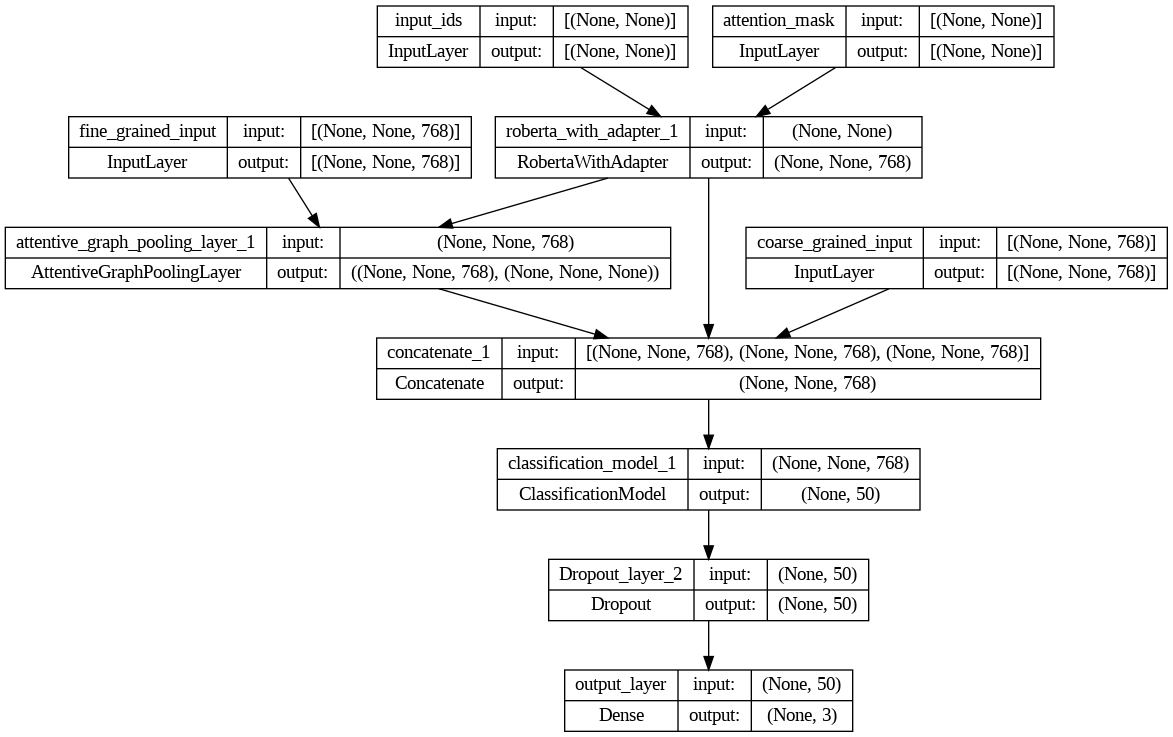

In [4]:
import tensorflow as tf
from transformers import TFRobertaModel, RobertaTokenizer
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.utils import plot_model
import numpy as np

model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)

class ClassificationModel(tf.keras.Model):
    def __init__(self, max_sequence_length, combined_embedding_dim):
        super(ClassificationModel, self).__init__()
        self.conv1d = Conv1D(filters=512, kernel_size=5, activation='relu', name='Conv1D_layer')
        self.max_pooling = MaxPooling1D(pool_size=2, name='MaxPooling_layer')
        self.bilstm = Bidirectional(LSTM(100, return_sequences=True), name='BiLSTM_layer')
        self.attention = tf.keras.layers.Attention(name='Attention_layer')
        self.global_max_pooling = GlobalMaxPooling1D(name='Attention_Pooling_layer')
        self.dense1 = Dense(100, activation='relu', name='Dense_layer_1')
        self.dropout1 = Dropout(0.6, name='Dropout_layer_1')
        self.dense2 = Dense(50, activation='relu', name='Dense_layer_2')

    def call(self, inputs):
        x = self.conv1d(inputs)
        x = self.max_pooling(x)
        x = self.bilstm(x)
        attention_output = self.attention([x, x])
        x = self.global_max_pooling(attention_output)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        return x

class AdapterLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, adapter_dim):
        super(AdapterLayer, self).__init__()
        self.linear1 = tf.keras.layers.Dense(adapter_dim, activation='relu')
        self.linear2 = tf.keras.layers.Dense(input_dim)

    def call(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

class RobertaWithAdapter(tf.keras.Model):
    def __init__(self, model_name, adapter_dim):
        super(RobertaWithAdapter, self).__init__()
        self.roberta = TFRobertaModel.from_pretrained(model_name)
        self.adapter = AdapterLayer(self.roberta.config.hidden_size, adapter_dim)

    def call(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        adapter_output = self.adapter(sequence_output)
        return adapter_output

class AttentiveGraphPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super(AttentiveGraphPoolingLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.WQ = tf.keras.layers.Dense(hidden_dim)
        self.WK = tf.keras.layers.Dense(hidden_dim)
        self.WV = tf.keras.layers.Dense(hidden_dim)

    def call(self, h, c):
        Q = self.WQ(h)
        K = self.WK(c)
        V = self.WV(c)

        attn_scores = tf.matmul(Q, K, transpose_b=True)
        attn_scores = attn_scores / tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32))

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)
        attended_values = tf.matmul(attn_weights, V)

        return attended_values, attn_weights


input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
fine_grained_input = Input(shape=(None, 768), dtype=tf.float32, name='fine_grained_input')
coarse_grained_input = Input(shape=(None, 768), dtype=tf.float32, name='coarse_grained_input')

roberta_with_adapter = RobertaWithAdapter(model_name, adapter_dim=64)
attention_layer = AttentiveGraphPoolingLayer(hidden_dim=768)
max_seq = roberta_with_adapter.roberta.config.max_position_embeddings
class_model = ClassificationModel(max_sequence_length=max_seq, combined_embedding_dim=768)

roberta_output = roberta_with_adapter(input_ids=input_ids, attention_mask=attention_mask)
attention_output, _ = attention_layer(fine_grained_input, roberta_output)


concatenated_input = Concatenate(axis=1)([roberta_output, attention_output, coarse_grained_input])

output_layer = class_model(concatenated_input)
dropout2 = Dropout(0.5, name='Dropout_layer_2')(output_layer)
output_layer = Dense(3, activation='softmax', name='output_layer')(dropout2)

final_model = Model(inputs=[input_ids, attention_mask, fine_grained_input, coarse_grained_input], outputs=output_layer)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
final_model.compile(optimizer=Nadam(learning_rate=0.001), loss=loss_fn, metrics=['accuracy'])

final_model.summary()
plot_model(final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [5]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/UBC_project/cleaned_data_no_special_characters.csv' ,encoding='utf-8')
df.sample(10)

,claims,claims_labels
3567,it may have have water ocean in the past but t...,NOT_ENOUGH_INFO
4770,threshold and boundary the threshold or tappin...,NOT_ENOUGH_INFO
4048,eventually other earth process offset these po...,NOT_ENOUGH_INFO
2888,there be a threshold in surface warming beyond...,NOT_ENOUGH_INFO
499,marine life have nothing whatsoever to fear fr...,REFUTES
127,the figure traditionally cite that suggest 97 ...,REFUTES
765,CO2 increase be natural not humancause,REFUTES
1104,when the Earth come out of an ice age the warm...,NOT_ENOUGH_INFO
886,Trudeaus carbon tax will raise gas price by 11...,NOT_ENOUGH_INFO
5847,three be locate at Goldstone and one each at C...,SUPPORTS


In [6]:
df = df[(df['claims'].str.split().str.len() > 3) & (df['claims'].str.split().str.len() < 20)]
df.shape

(3850, 2)

Balanced Class Distribution:
claims_labels
SUPPORTS           1099
NOT_ENOUGH_INFO    1099
REFUTES            1099
Name: count, dtype: int64


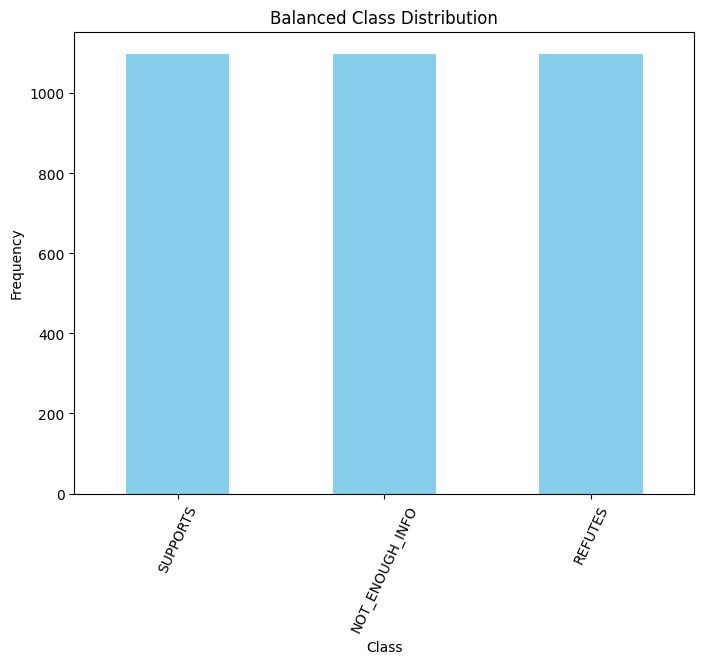

In [7]:
import matplotlib.pyplot as plt
min_class_size = min(df['claims_labels'].value_counts())

balanced_train_data = pd.DataFrame(columns=['claims','claims_labels'])

class_distribution = df['claims_labels'].value_counts()

for genre, count in class_distribution.items():
  class_data = df[df['claims_labels'] == genre].sample(n=min_class_size, random_state=22)
  balanced_train_data = pd.concat([balanced_train_data, class_data], ignore_index=True)

balanced_train_data.describe()
balanced_class_distribution = balanced_train_data['claims_labels'].value_counts()

print("Balanced Class Distribution:")
print(balanced_class_distribution)

plt.figure(figsize=(8, 6))
balanced_class_distribution.plot(kind='bar', color='skyblue')
plt.title('Balanced Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=65)
plt.show()

df = balanced_train_data


In [8]:
def ohe(text):

    if text=='SUPPORTS':
         return 2
    elif text=='NOT_ENOUGH_INFO':
         return 1
    elif text=='REFUTES' :
          return 0
    return 0

df['claims_labels']=df['claims_labels'].apply(lambda x:ohe(x))

df=df.sample(n=100,random_state=22)
df.shape

(100, 2)

In [9]:
df

,claims,claims_labels
1396,the ocean will never become acid because there...,1
3092,it be also the hot summer for England since re...,0
2130,lead global model produce quite different resu...,1
59,here be all the promising development ofll be ...,2
3138,the Environmental Working Group deem Fruit the...,0
...,...,...
1484,the australian government Missions Reduction F...,1
3149,its a new world for global warmingpowere wildl...,0
2949,throw away leftover doesnt just waste food,0
2230,theyre likely to go where they have friend fam...,0


In [10]:
import numpy as np

input_ids = []
attention_masks = []
fine_grained_inputs = []
coarse_grained_inputs = []
labels = []
def generate_model_input(df, tokenizer):

  count = 0
  for index, row in df.iterrows():

    text = row['claims']
    label = row['claims_labels']
    count += 1
    print(count)

    roberta_input = tokenizer(text, return_tensors='tf', truncation=True, padding=True)
    contextual_vectors_coarse, contextual_vectors_fine = get_contextual_representations(text)


    input_ids.append(roberta_input['input_ids'].numpy()[0])
    attention_masks.append(roberta_input['attention_mask'].numpy()[0])

    if contextual_vectors_fine is not None:
      fine_grained_inputs.append(contextual_vectors_fine.numpy())
    else:
      fine_grained_inputs.append(np.empty((0, 768)))

    if contextual_vectors_coarse is not None:
      coarse_grained_inputs.append(contextual_vectors_coarse.numpy())
    else:
      coarse_grained_inputs.append(np.empty((0, 768)))

    labels.append(label)


generate_model_input(df, tokenizer)


1
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
2


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}
en.wikipedia.org (parse) England
England (en) data
{
  infobox: <dict(42)> image_flag, national_anthem, status, capital...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/England, h...
  pageid: 9316
  parsetree: <str(318571)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: England
  wikibase: Q21
  wikidata_url: https://www.wikidata.org/wiki/

Epoch 10/20, Loss: 0.6066173315048218
Epoch 20/20, Loss: 0.3144289255142212
Epoch 10/20, Loss: 0.1256544291973114
Epoch 20/20, Loss: 0.13283254206180573
3
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
4


en.wikipedia.org (parse) Paris
Paris (en) data
{
  image: <list(0)> 
  infobox: <dict(35)> name, commune status, image, image coat of a...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Paris, ht...
  pageid: 22989
  parsetree: <str(397763)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Paris
  wikibase: Q90
  wikidata_url: https://www.wikidata.org/wiki/Q90
  wikitext: <str(251325)> {{Short description|Capital and largest ...
}
en.wikipedia.org (parse) this week
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=this%20week
Epoch 10/20, Loss: 0.6527053117752075
Epoch 20/20, Loss: 0.39740845561027527
Epoch 10/20, Loss: 0.3647269010543823
Epoch 20/20, Loss: 0.2062137871980667
5


en.wikipedia.org (parse) the Environmental Working Group
en.wikipedia.org (imageinfo) File:Environmental Working Group.svg
Environmental Working Group (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Environme...
  infobox: <dict(9)> name, image, image_size, type, founded_date, ...
  pageid: 1602649
  parsetree: <str(29276)> <root><template><title>Short description...
  requests: <list(2)> parse, imageinfo
  title: Environmental Working Group
  wikibase: Q928450
  wikidata_url: https://www.wikidata.org/wiki/Q928450
  wikitext: <str(23199)> {{Short description|American activist gro...
}
en.wikipedia.org (parse) its year
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=its%20year
Epoch 10/20, Loss: 0.8396128416061401
Epoch 20/20, Loss: 0.3724501132965088
Epoch 10/20, Loss: 0.23009365797042847
Epoch 20/20, Loss: 4.207031726837158
6


en.wikipedia.org (parse) the Framework Convention
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 1992


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20Framework%20Convention


1992 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1992
  pageid: 34669
  parsetree: <str(54563)> <root><template><title>Globalize</title>...
  requests: <list(1)> parse
  title: 1992
  wikibase: Q2060
  wikidata_url: https://www.wikidata.org/wiki/Q2060
  wikitext: <str(48024)> {{Globalize|date=June 2019}}{{Use mdy dat...
}


Epoch 10/20, Loss: 0.5635088682174683
Epoch 20/20, Loss: 0.4930838644504547
Epoch 10/20, Loss: 0.77958744764328
Epoch 20/20, Loss: 5.401462078094482
7
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
8
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
9


en.wikipedia.org (parse) Gronewold
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Gronewold
Epoch 10/20, Loss: 0.13903354108333588
Epoch 20/20, Loss: 0.42601367831230164
Epoch 10/20, Loss: 2.4514248371124268
Epoch 20/20, Loss: 0.13722851872444153
10
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
11
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
12
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
13
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
14


en.wikipedia.org (parse) century past
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=century%20past
Epoch 10/20, Loss: 1.3955799341201782
Epoch 20/20, Loss: 0.17755119502544403
Epoch 10/20, Loss: 0.17692352831363678
Epoch 20/20, Loss: 0.17646443843841553
15


en.wikipedia.org (parse) ice berg melt ocean level
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=ice%20berg%20melt%20ocean%20level
Epoch 10/20, Loss: 0.1558021605014801
Epoch 20/20, Loss: 0.1553920954465866
Epoch 10/20, Loss: 2.9670753479003906
Epoch 20/20, Loss: 0.6391051411628723
16


en.wikipedia.org (parse) Thick arctic sea
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Thick%20arctic%20sea
Epoch 10/20, Loss: 0.16825824975967407
Epoch 20/20, Loss: 0.16767729818820953
Epoch 10/20, Loss: 0.16690389811992645
Epoch 20/20, Loss: 0.1663922518491745
17


en.wikipedia.org (parse) Earth
en.wikipedia.org (imageinfo) File:The Blue Marble (remastered).jpg
Earth (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:The Blue ...
  infobox: <dict(50)> background, name, alt_names, adjectives, sym...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/Category:...
  pageid: 9228
  parsetree: <str(294468)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Earth
  wikibase: Q2
  wikidata_url: https://www.wikidata.org/wiki/Q2
  wikitext: <str(221745)> {{Short description|Third planet from th...
}


Epoch 10/20, Loss: 0.5176406502723694
Epoch 20/20, Loss: 0.522966206073761
Epoch 10/20, Loss: 0.2356850802898407
Epoch 20/20, Loss: 0.5487783551216125
18
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
19


en.wikipedia.org (parse) 20
20 (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/twenty
  pageid: 478475
  parsetree: <str(4152)> <root><template><title>technical reasons<...
  requests: <list(1)> parse
  title: 20
  wikibase: Q1166637
  wikidata_url: https://www.wikidata.org/wiki/Q1166637
  wikitext: <str(3019)> {{technical reasons|20 #1s Now|that album|...
}
en.wikipedia.org (parse) 200510
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=200510
Epoch 10/20, Loss: 0.22939635813236237
Epoch 20/20, Loss: 0.19787223637104034
Epoch 10/20, Loss: 0.8503467440605164
Epoch 20/20, Loss: 0.16173245012760162
20
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
21
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
22


en.wikipedia.org (parse) Nations Top Scientists
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) Innovators


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Nations%20Top%20Scientists


Innovation (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:I...
  pageid: 118450
  parsetree: <str(104835)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Innovation
  wikibase: Q174165
  wikidata_url: https://www.wikidata.org/wiki/Q174165
  wikitext: <str(87454)> {{Short description|Practical implementat...
}


Epoch 10/20, Loss: 1.0621027946472168
Epoch 20/20, Loss: 0.6426035165786743
Epoch 10/20, Loss: 1.1765872240066528
Epoch 20/20, Loss: 0.1777399331331253
23


en.wikipedia.org (parse) Greenland
Greenland (en) data
{
  infobox: <dict(85)> name, native_name, settlement_type, image_fl...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Gr%C3%B8nl...
  pageid: 12118
  parsetree: <str(233996)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Greenland
  wikibase: Q223
  wikidata_url: https://www.wikidata.org/wiki/Q223
  wikitext: <str(182032)> {{short description|Autonomous territory...
}
en.wikipedia.org (parse) Antarctica
en.wikipedia.org (imageinfo) File:Antarctica (orthographic projec...
Antarctica (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Antarctic...
  infobox: <dict(16)> title, image, image_size, alt, flag, area, p...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Antarctica...
  pageid: 18959138
  parsetree: <str(213255)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Antarctica
  wikibase: Q51
  wikidata_url: https://www.

Epoch 10/20, Loss: 0.6898108124732971
Epoch 20/20, Loss: 0.42381349205970764
Epoch 10/20, Loss: 0.24669845402240753
Epoch 20/20, Loss: 0.2811881899833679
24
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
25


en.wikipedia.org (parse) Nuccitelli
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) democratic


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Nuccitelli


Democrat (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Democrat, http...
  pageid: 8142
  parsetree: <str(3421)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Democrat
  wikibase: Q342240
  wikidata_url: https://www.wikidata.org/wiki/Q342240
  wikitext: <str(2490)> {{wiktionary|Democrat|democrat|Democratic|...
}


Epoch 10/20, Loss: 0.3804497718811035
Epoch 20/20, Loss: 0.4774560332298279
Epoch 10/20, Loss: 1.968002200126648
Epoch 20/20, Loss: 1.9318901300430298
26


en.wikipedia.org (parse) Squamish
Squamish (en) data
{
  pageid: 5871686
  parsetree: <str(1294)> <root><template><title>distinguish</title...
  requests: <list(1)> parse
  title: Squamish
  wikibase: Q399881
  wikidata_url: https://www.wikidata.org/wiki/Q399881
  wikitext: <str(992)> {{distinguish|Suquamish (disambiguation)|Sq...
}


Epoch 10/20, Loss: 0.26686108112335205
Epoch 20/20, Loss: 0.4041392505168915
Epoch 10/20, Loss: 0.15535177290439606
Epoch 20/20, Loss: 0.15475142002105713
27
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
28
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
29


en.wikipedia.org (parse) Britain
Britain (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/Britain
  pageid: 3745
  parsetree: <str(2419)> <root><template><title>Wiktionary</title>...
  requests: <list(1)> parse
  title: Britain
  wikibase: Q4798430
  wikidata_url: https://www.wikidata.org/wiki/Q4798430
  wikitext: <str(1862)> {{Wiktionary|Britain}}'''Britain''' most o...
}


Epoch 10/20, Loss: 0.2511405348777771
Epoch 20/20, Loss: 0.17906279861927032
Epoch 10/20, Loss: 0.1591661125421524
Epoch 20/20, Loss: 18.449186325073242
30
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
31


en.wikipedia.org (parse) 1992
1992 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:1992
  pageid: 34669
  parsetree: <str(54563)> <root><template><title>Globalize</title>...
  requests: <list(1)> parse
  title: 1992
  wikibase: Q2060
  wikidata_url: https://www.wikidata.org/wiki/Q2060
  wikitext: <str(48024)> {{Globalize|date=June 2019}}{{Use mdy dat...
}
en.wikipedia.org (parse) 2017
2017 (en) data
{
  pageid: 51389
  parsetree: <str(71096)> <root><template><title>About</title><par...
  requests: <list(1)> parse
  title: 2017
  wikibase: Q25290
  wikidata_url: https://www.wikidata.org/wiki/Q25290
  wikitext: <str(62452)> {{About|the year 2017|the number|2017 (nu...
}


Epoch 10/20, Loss: 0.4330560564994812
Epoch 20/20, Loss: 0.2837807834148407
Epoch 10/20, Loss: 0.39543452858924866
Epoch 20/20, Loss: 0.6852455139160156
32


en.wikipedia.org (parse) seven
7 (disambiguation) (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/7, https://en....
  pageid: 3108369
  parsetree: <str(11155)> <root><template><title>wiktionary</title...
  requests: <list(1)> parse
  title: 7 (disambiguation)
  wikibase: Q2752634
  wikidata_url: https://www.wikidata.org/wiki/Q2752634
  wikitext: <str(9949)> {{wiktionary|7|seven}}'''[[7]]''' is a num...
}
en.wikipedia.org (parse) 10
10 (en) data
{
  infobox: <dict(30)> number, numeral, divisor, roman unicode, gre...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Category:1...
  pageid: 208151
  parsetree: <str(35420)> <root><template><title>Hatnote</title><p...
  requests: <list(1)> parse
  title: 10
  wikibase: Q23806
  wikidata_url: https://www.wikidata.org/wiki/Q23806
  wikitext: <str(25930)> {{Hatnote|This article is about the numbe...
}
en.wikipedia.org (parse) Americans
Americans (en) data
{
  infobox: <dict(52)> group, native_name_lang, flag, flag_caption

Epoch 10/20, Loss: 0.43595340847969055
Epoch 20/20, Loss: 0.26487088203430176
Epoch 10/20, Loss: 0.20360542833805084
Epoch 20/20, Loss: 0.17757833003997803
33
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
34
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
35
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
36


en.wikipedia.org (parse) one
1 (en) data
{
  infobox: <dict(38)> number, numeral, factorization, divisor, rom...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/1_(number)...
  pageid: 22770
  parsetree: <str(75936)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 1
  wikibase: Q199
  wikidata_url: https://www.wikidata.org/wiki/Q199
  wikitext: <str(36782)> {{Short description|Number}}{{Hatnote|Thi...
}


Epoch 10/20, Loss: 0.6631456613540649
Epoch 20/20, Loss: 0.6227889657020569
Epoch 10/20, Loss: 0.6744152307510376
Epoch 20/20, Loss: 0.3591609597206116
37
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
38


en.wikipedia.org (parse) the River Thames
en.wikipedia.org (imageinfo) File:By The River Thames at Vauxhall...
River Thames (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:By The Ri...
  infobox: <dict(37)> name, name_etymology, image, image_caption, ...
  iwlinks: <list(4)> https://commons.wikimedia.org/wiki/Category:R...
  pageid: 49031
  parsetree: <str(171603)> <root><template><title>short descriptio...
  requests: <list(2)> parse, imageinfo
  title: River Thames
  wikibase: Q19686
  wikidata_url: https://www.wikidata.org/wiki/Q19686
  wikitext: <str(136672)> {{short description|River in southern En...
}
en.wikipedia.org (parse) two decade
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API depreca

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=two%20decade
Epoch 10/20, Loss: 0.5847918391227722
Epoch 20/20, Loss: 0.3718326985836029
Epoch 10/20, Loss: 0.4604590833187103
Epoch 20/20, Loss: 0.2022726833820343
39
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
40


en.wikipedia.org (parse) 1 billion
Billion (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/billion
  pageid: 47182594
  parsetree: <str(8196)> <root><template><title>Use mdy dates</tit...
  requests: <list(1)> parse
  title: Billion
  wikibase: Q12535449
  wikidata_url: https://www.wikidata.org/wiki/Q12535449
  wikitext: <str(6354)> {{Use mdy dates|date=November 2023}}{{Shor...
}
en.wikipedia.org (parse) World Good Program
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=World%20Good%20Program
Epoch 10/20, Loss: 0.5885342955589294
Epoch 20/20, Loss: 0.3420664370059967
Epoch 10/20, Loss: 1.0641636848449707
Epoch 20/20, Loss: 0.1755971759557724
41


en.wikipedia.org (parse) 26 million
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) 2016


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=26%20million


2016 (en) data
{
  pageid: 51387
  parsetree: <str(58548)> <root><template><title>for</title><part>...
  requests: <list(1)> parse
  title: 2016
  wikibase: Q25245
  wikidata_url: https://www.wikidata.org/wiki/Q25245
  wikitext: <str(51096)> {{for|the number|2016 (number)}}{{pp-move...
}


Epoch 10/20, Loss: 0.7738797664642334
Epoch 20/20, Loss: 0.6175062656402588
Epoch 10/20, Loss: 1.0798650979995728
Epoch 20/20, Loss: 0.5553421974182129
42
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
43


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}


Epoch 10/20, Loss: 0.40010491013526917
Epoch 20/20, Loss: 0.47307825088500977
Epoch 10/20, Loss: 0.8409483432769775
Epoch 20/20, Loss: 0.9479878544807434
44


en.wikipedia.org (parse) Pakistan
Pakistan (en) data
{
  infobox: <dict(85)> conventional_long_name, common_name, native_...
  iwlinks: <list(12)> https://commons.wikimedia.org/wiki/%D9%BE%D8...
  pageid: 23235
  parsetree: <str(653684)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Pakistan
  wikibase: Q843
  wikidata_url: https://www.wikidata.org/wiki/Q843
  wikitext: <str(364158)> {{short description|Country in South Asi...
}


Epoch 10/20, Loss: 0.6556844115257263
Epoch 20/20, Loss: 0.41574856638908386
Epoch 10/20, Loss: 0.15725137293338776
Epoch 20/20, Loss: 0.5624862909317017
45
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
46


en.wikipedia.org (parse) Antarctica
en.wikipedia.org (imageinfo) File:Antarctica (orthographic projec...
Antarctica (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Antarctic...
  infobox: <dict(16)> title, image, image_size, alt, flag, area, p...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Antarctica...
  pageid: 18959138
  parsetree: <str(213255)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Antarctica
  wikibase: Q51
  wikidata_url: https://www.wikidata.org/wiki/Q51
  wikitext: <str(140478)> {{Short description|Earth's southernmost...
}


Epoch 10/20, Loss: 0.67378830909729
Epoch 20/20, Loss: 0.5592666268348694
Epoch 10/20, Loss: 0.18003584444522858
Epoch 20/20, Loss: 0.7226397395133972
47


en.wikipedia.org (parse) Holmes
Holmes (en) data
{
  iwlinks: <list(2)> https://en.wiktionary.org/wiki/Holmes, https:...
  pageid: 17360415
  parsetree: <str(3391)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Holmes
  wikibase: Q230472
  wikidata_url: https://www.wikidata.org/wiki/Q230472
  wikitext: <str(2714)> {{wiktionary|Holmes|holmes}}'''Holmes''' m...
}


Epoch 10/20, Loss: 0.6940182447433472
Epoch 20/20, Loss: 0.532707154750824
Epoch 10/20, Loss: 2.536808967590332
Epoch 20/20, Loss: 0.14097613096237183
48


en.wikipedia.org (parse) the National Geographic
National Geographic (en) data
{
  infobox: <dict(19)> title, logo, image_file, image_alt, image_ca...
  iwlinks: <list(3)> https://archive.org/details/NationalGeographi...
  pageid: 229466
  parsetree: <str(156595)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: National Geographic
  wikibase: Q5973845
  wikidata_url: https://www.wikidata.org/wiki/Q5973845
  wikitext: <str(102892)> {{Short description|Monthly geography, h...
}
en.wikipedia.org (parse) as six decade
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=as%20six%20decade
Epoch 10/20, Loss: 0.6591758131980896
Epoch 20/20, Loss: 0.47315701842308044
Epoch 10/20, Loss: 0.8560895919799805
Epoch 20/20, Loss: 0.25218501687049866
49
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
50


en.wikipedia.org (parse) Change Baths
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Change%20Baths
Epoch 10/20, Loss: 39.00434875488281
Epoch 20/20, Loss: 0.19099213182926178
Epoch 10/20, Loss: 0.19038785994052887
Epoch 20/20, Loss: 1.2712491750717163
51


en.wikipedia.org (parse) brazil
Brazil (en) data
{
  infobox: <dict(87)> conventional_long_name, common_name, native_...
  iwlinks: <list(13)> https://archive.org/details/historyofmodernb...
  pageid: 3383
  parsetree: <str(376208)> <root><template><title>short descriptio...
  requests: <list(1)> parse
  title: Brazil
  wikibase: Q155
  wikidata_url: https://www.wikidata.org/wiki/Q155
  wikitext: <str(291526)> {{short description|Country in South Ame...
}
en.wikipedia.org (parse) the ministry of agriculture
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20ministry%20of%20agriculture
Epoch 10/20, Loss: 0.6734148859977722
Epoch 20/20, Loss: 0.36646103858947754
Epoch 10/20, Loss: 0.18255138397216797
Epoch 20/20, Loss: 0.2454313337802887
52


en.wikipedia.org (parse) GWP
GWP (en) data
{
  pageid: 891208
  parsetree: <str(729)> <root>'''GWP''' may refer to:<h level="2" ...
  requests: <list(1)> parse
  title: GWP
  wikibase: Q591563
  wikidata_url: https://www.wikidata.org/wiki/Q591563
  wikitext: <str(566)> '''GWP''' may refer to:==Places==* [[Galbre...
}


Epoch 10/20, Loss: 0.5270093679428101
Epoch 20/20, Loss: 0.9719655513763428
Epoch 10/20, Loss: 1.030463457107544
Epoch 20/20, Loss: 0.6494799852371216
53
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
54
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
55


en.wikipedia.org (parse) 800 year later
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=800%20year%20later
Epoch 10/20, Loss: 25.25752830505371
Epoch 20/20, Loss: 0.18551702797412872
Epoch 10/20, Loss: 0.18431122601032257
Epoch 20/20, Loss: 0.1838194876909256
56
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
57


en.wikipedia.org (parse) Australia
Australia (en) data
{
  infobox: <dict(77)> conventional_long_name, common_name, image_f...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/Atlas_of_...
  pageid: 4689264
  parsetree: <str(334639)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Australia
  wikibase: Q408
  wikidata_url: https://www.wikidata.org/wiki/Q408
  wikitext: <str(273343)> {{Short description|Country in Oceania}}...
}
en.wikipedia.org (parse) annual
Annual (en) data
{
  iwlinks: <list(3)> https://en.wiktionary.org/wiki/annual, https:...
  pageid: 179451
  parsetree: <str(704)> <root><template><title>wiktionary</title><...
  requests: <list(1)> parse
  title: Annual
  wikibase: Q567353
  wikidata_url: https://www.wikidata.org/wiki/Q567353
  wikitext: <str(458)> {{wiktionary|annual|annually|yearly}}'''Ann...
}


Epoch 10/20, Loss: 0.5136970281600952
Epoch 20/20, Loss: 0.36909639835357666
Epoch 10/20, Loss: 4.000169277191162
Epoch 20/20, Loss: 0.21286343038082123
58


en.wikipedia.org (parse) winter
en.wikipedia.org (imageinfo) File:Winter forest silver.jpg
Winter (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Winter fo...
  infobox: <dict(9)> title, image, caption, sdate1, sdate2, sdate3...
  iwlinks: <list(5)> https://commons.wikimedia.org/wiki/Category:W...
  pageid: 34061
  parsetree: <str(42093)> <root><template><title>short description...
  requests: <list(2)> parse, imageinfo
  title: Winter
  wikibase: Q1311
  wikidata_url: https://www.wikidata.org/wiki/Q1311
  wikitext: <str(35301)> {{short description|Coldest of the four t...
}


Epoch 10/20, Loss: 0.7129488587379456
Epoch 20/20, Loss: 0.5641626715660095
Epoch 10/20, Loss: 0.28435131907463074
Epoch 20/20, Loss: 0.25996384024620056
59


en.wikipedia.org (parse) National Dark Service
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=National%20Dark%20Service
Epoch 10/20, Loss: 3.0139198303222656
Epoch 20/20, Loss: 3.6363227367401123
Epoch 10/20, Loss: 6.6260294914245605
Epoch 20/20, Loss: 23.251970291137695
60
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
61
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
62
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
63
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
64


en.wikipedia.org (parse) James Thornton
James Thornton (en) data
{
  pageid: 1943664
  parsetree: <str(1416)> <root>'''James Thornton''' may refer to:<...
  requests: <list(1)> parse
  title: James Thornton
  wikibase: Q11783317
  wikidata_url: https://www.wikidata.org/wiki/Q11783317
  wikitext: <str(1231)> '''James Thornton''' may refer to:==Entert...
}


Epoch 10/20, Loss: 0.2009797990322113
Epoch 20/20, Loss: 0.13489601016044617
Epoch 10/20, Loss: 0.138722762465477
Epoch 20/20, Loss: 0.13828657567501068
65
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
66


en.wikipedia.org (parse) 09 degree
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) about 35 year ago


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=09%20degree
An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=about%2035%20year%20ago


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


Epoch 10/20, Loss: 0.49235713481903076
Epoch 20/20, Loss: 0.17168371379375458
Epoch 10/20, Loss: 0.17113953828811646
Epoch 20/20, Loss: 5.738710880279541
67
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
68


en.wikipedia.org (parse) Antarctica
en.wikipedia.org (imageinfo) File:Antarctica (orthographic projec...
Antarctica (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Antarctic...
  infobox: <dict(16)> title, image, image_size, alt, flag, area, p...
  iwlinks: <list(7)> https://commons.wikimedia.org/wiki/Antarctica...
  pageid: 18959138
  parsetree: <str(213255)> <root><template><title>Short descriptio...
  requests: <list(2)> parse, imageinfo
  title: Antarctica
  wikibase: Q51
  wikidata_url: https://www.wikidata.org/wiki/Q51
  wikitext: <str(140478)> {{Short description|Earth's southernmost...
}
en.wikipedia.org (parse) 15 million
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and bre

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=15%20million
Epoch 10/20, Loss: 0.8540566563606262
Epoch 20/20, Loss: 0.5429882407188416
Epoch 10/20, Loss: 1.0583593845367432
Epoch 20/20, Loss: 0.502178966999054
69


en.wikipedia.org (parse) Scene
Scene (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/scene
  pageid: 697267
  parsetree: <str(4078)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Scene
  wikibase: Q345264
  wikidata_url: https://www.wikidata.org/wiki/Q345264
  wikitext: <str(3133)> {{wiktionary|scene}}'''Scene''' (from [[An...
}


Epoch 10/20, Loss: 0.6705618500709534
Epoch 20/20, Loss: 0.46795567870140076
Epoch 10/20, Loss: 23.47259521484375
Epoch 20/20, Loss: 7.2498908042907715
70


en.wikipedia.org (parse) Vancouver
Vancouver (en) data
{
  infobox: <dict(69)> name, official_name, settlement_type, image_...
  iwlinks: <list(8)> https://commons.wikimedia.org/wiki/Vancouver,...
  pageid: 32706
  parsetree: <str(267642)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Vancouver
  wikibase: Q24639
  wikidata_url: https://www.wikidata.org/wiki/Q24639
  wikitext: <str(208766)> {{Short description|City in British Colu...
}
en.wikipedia.org (parse) first
First (en) data
{
  iwlinks: <list(1)> https://en.wiktionary.org/wiki/first
  pageid: 620465
  parsetree: <str(3860)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: First
  wikibase: Q351401
  wikidata_url: https://www.wikidata.org/wiki/Q351401
  wikitext: <str(2994)> {{wiktionary|first}}'''First''' or '''1st'...
}
en.wikipedia.org (parse) canadian
Canadians (en) data
{
  infobox: <dict(33)> group, flag, flag_caption, pop, regions, reg...
  iwlinks: <list(

Epoch 10/20, Loss: 0.5478157997131348
Epoch 20/20, Loss: 0.4030756950378418
Epoch 10/20, Loss: 0.09881501644849777
Epoch 20/20, Loss: 0.08819975703954697
71
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
72


en.wikipedia.org (parse) John Solemn
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=John%20Solemn
Epoch 10/20, Loss: 0.1497294157743454
Epoch 20/20, Loss: 1.9173964262008667
Epoch 10/20, Loss: 0.14881794154644012
Epoch 20/20, Loss: 8.333125114440918
73
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
74


en.wikipedia.org (parse) Diam Republican
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Diam%20Republican


en.wikipedia.org (parse) Arctic
Arctic (en) data
{
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Arctic, h...
  pageid: 36971
  parsetree: <str(73005)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Arctic
  wikibase: Q25322
  wikidata_url: https://www.wikidata.org/wiki/Q25322
  wikitext: <str(60284)> {{Short description|Polar region of the E...
}


Epoch 10/20, Loss: 0.9662873148918152
Epoch 20/20, Loss: 0.6653124690055847
Epoch 10/20, Loss: 0.15012453496456146
Epoch 20/20, Loss: 0.2429465502500534
75


en.wikipedia.org (parse) between 01 and 15
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=between%2001%20and%2015
Epoch 10/20, Loss: 0.17074044048786163
Epoch 20/20, Loss: 0.17026591300964355
Epoch 10/20, Loss: 0.16953153908252716
Epoch 20/20, Loss: 0.16895116865634918
76
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
77


en.wikipedia.org (parse) 2
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54360)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35370)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 0.5704019069671631
Epoch 20/20, Loss: 0.2855296730995178
Epoch 10/20, Loss: 0.9289783239364624
Epoch 20/20, Loss: 0.24006561934947968
78
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
79


en.wikipedia.org (parse) 09
09 (en) data
{
  pageid: 16588475
  parsetree: <str(530)> <root>'''09''' may refer to:* The year [[2...
  requests: <list(1)> parse
  title: 09
  wikibase: Q1178615
  wikidata_url: https://www.wikidata.org/wiki/Q1178615
  wikitext: <str(448)> '''09''' may refer to:* The year [[2009]], ...
}


Epoch 10/20, Loss: 0.38500532507896423
Epoch 20/20, Loss: 0.4006618857383728
Epoch 10/20, Loss: 0.15487466752529144
Epoch 20/20, Loss: 0.15457941591739655
80
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
81
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
82
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
83
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
84
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
85


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}
en.wikipedia.org (parse) June July
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking chan

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=June%20July


August (en) data
{
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Category:A...
  pageid: 1005
  parsetree: <str(34104)> <root><template><title>short description...
  requests: <list(1)> parse
  title: August
  wikibase: Q122
  wikidata_url: https://www.wikidata.org/wiki/Q122
  wikitext: <str(29714)> {{short description|Eighth month in the J...
}
en.wikipedia.org (parse) 32
32 (en) data
{
  iwlinks: <list(5)> https://en.wiktionary.org/wiki/32, https://en...
  pageid: 38345630
  parsetree: <str(3607)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: 32
  wikibase: Q4635004
  wikidata_url: https://www.wikidata.org/wiki/Q4635004
  wikitext: <str(1770)> {{wiktionary|32|XXXII|thirty-two}}'''32'''...
}


Epoch 10/20, Loss: 0.6191659569740295
Epoch 20/20, Loss: 0.3099622428417206
Epoch 10/20, Loss: 0.47505804896354675
Epoch 20/20, Loss: 1.5321451425552368
86


en.wikipedia.org (parse) Less than half
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) publish


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Less%20than%20half


Publishing (en) data
{
  infobox: <dict(5)> by, onlinebooks, others, about, label
  iwlinks: <list(6)> https://commons.wikimedia.org/wiki/category:P...
  pageid: 68761
  parsetree: <str(49691)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: Publishing
  wikibase: Q3972943
  wikidata_url: https://www.wikidata.org/wiki/Q3972943
  wikitext: <str(42667)> {{Short description|Process of production...
}


Epoch 10/20, Loss: 1.4801111221313477
Epoch 20/20, Loss: 0.6077864766120911
Epoch 10/20, Loss: 0.4592742919921875
Epoch 20/20, Loss: 0.16768169403076172
87


en.wikipedia.org (parse) 2
2 (en) data
{
  infobox: <dict(37)> number, ordinal, numeral, prime, divisor, ro...
  iwlinks: <list(11)> https://commons.wikimedia.org/wiki/2_(number...
  pageid: 64516
  parsetree: <str(54360)> <root><template><title>Short description...
  requests: <list(1)> parse
  title: 2
  wikibase: Q200
  wikidata_url: https://www.wikidata.org/wiki/Q200
  wikitext: <str(35370)> {{Short description|Integer number 2}}{{p...
}


Epoch 10/20, Loss: 0.7456095218658447
Epoch 20/20, Loss: 0.39144229888916016
Epoch 10/20, Loss: 0.33695685863494873
Epoch 20/20, Loss: 1.1764087677001953
88
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
89
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
90
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
91


en.wikipedia.org (parse) Hippocrates and Medical Education
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) the XIIth International Hippocrates Coll...


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Hippocrates%20and%20Medical%20Education
An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20XIIth%20International%20Hippocrates%20Colloquium%20Universiteit


API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) August 2005
2005 (en) data
{
  iwlinks: <list(1)> https://commons.wikimedia.org/wiki/Category:2005
  pageid: 35984
  parsetree: <str(51744)> <root><template><title>pp-move</title></...
  requests: <list(1)> parse
  title: 2005
  wikibase: Q2019
  wikidata_url: https://www.wikidata.org/wiki/Q2019
  wikitext: <str(43890)> {{pp-move}}{{pp-pc|small=yes}}{{Use mdy d...
}


Epoch 10/20, Loss: 0.7815598845481873
Epoch 20/20, Loss: 0.40333282947540283
Epoch 10/20, Loss: 1.623787522315979
Epoch 20/20, Loss: 0.6312804818153381
92


en.wikipedia.org (parse) the Supreme Court
Supreme court (en) data
{
  pageid: 4913027
  parsetree: <str(61578)> <root><template><title>short description...
  requests: <list(1)> parse
  title: Supreme court
  wikibase: Q190752
  wikidata_url: https://www.wikidata.org/wiki/Q190752
  wikitext: <str(53550)> {{short description|Highest court in a ju...
}


Epoch 10/20, Loss: 0.7684892416000366
Epoch 20/20, Loss: 0.5514916777610779
Epoch 10/20, Loss: 1.1417402029037476
Epoch 20/20, Loss: 1.9154332876205444
93
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
94


en.wikipedia.org (parse) the National Oceanic and Atmospheric Adm...
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=the%20National%20Oceanic%20and%20Atmospheric%20Administration%20NOAA
Epoch 10/20, Loss: 0.18213456869125366
Epoch 20/20, Loss: 2.549325942993164
Epoch 10/20, Loss: 0.18082712590694427
Epoch 20/20, Loss: 10.099380493164062
95
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
96


en.wikipedia.org (parse) australian
Australian (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Australian, ht...
  pageid: 92590
  parsetree: <str(1706)> <root><template><title>wiktionary</title>...
  requests: <list(1)> parse
  title: Australian
  wikibase: Q532611
  wikidata_url: https://www.wikidata.org/wiki/Q532611
  wikitext: <str(1082)> {{wiktionary|Australian|australian|Austral...
}
en.wikipedia.org (parse) Missions Reduction Fund
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}
en.wikipedia.org (parse) australian
Australian (en) data
{
  iwlinks: <list(4)> https://en.wiktionary.org/wiki/Australian, ht...
  pageid: 92590
  parsetree: <str(1706)> <root><template

An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=Missions%20Reduction%20Fund
Epoch 10/20, Loss: 0.35762038826942444
Epoch 20/20, Loss: 0.391966313123703
Epoch 10/20, Loss: 1.8378816843032837
Epoch 20/20, Loss: 1.022157907485962
97
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
98
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
99
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
100
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.


In [11]:
padded_input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post')
padded_attention_masks = tf.keras.preprocessing.sequence.pad_sequences(attention_masks, padding='post')
padded_fine_grained_inputs = tf.keras.preprocessing.sequence.pad_sequences(fine_grained_inputs, padding='post',dtype='float32')
padded_coarse_grained_inputs = tf.keras.preprocessing.sequence.pad_sequences(coarse_grained_inputs, padding='post',dtype='float32')

final_model.fit([padded_input_ids, padded_attention_masks, padded_fine_grained_inputs, padded_coarse_grained_inputs], np.array(labels), epochs=30 , batch_size=25)

Epoch 1/30


4/4 [==============================] - 216s 33s/step - loss: 1.3305 - accuracy: 0.2900
Epoch 2/30
4/4 [==============================] - 136s 35s/step - loss: 1.1179 - accuracy: 0.3500
Epoch 3/30
4/4 [==============================] - 134s 34s/step - loss: 1.1325 - accuracy: 0.3500
Epoch 4/30
4/4 [==============================] - 139s 35s/step - loss: 1.0730 - accuracy: 0.4200
Epoch 5/30
4/4 [==============================] - 139s 35s/step - loss: 1.0774 - accuracy: 0.3200
Epoch 6/30
4/4 [==============================] - 139s 35s/step - loss: 1.0029 - accuracy: 0.4900
Epoch 7/30
4/4 [==============================] - 134s 33s/step - loss: 1.0190 - accuracy: 0.5000
Epoch 8/30
4/4 [==============================] - 139s 35s/step - loss: 0.9741 - accuracy: 0.4900
Epoch 9/30
4/4 [==============================] - 134s 33s/step - loss: 0.9779 - accuracy: 0.5200
Epoch 10/30
4/4 [==============================] - 139s 35s/step - loss: 0.9102 - accuracy: 0.5300
Epoch 11/30
4/4 [=============